<a href="https://colab.research.google.com/github/boomyun713/114_homework/blob/main/W8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
from statsmodels.tsa.arima.model import ARIMA
import math
import warnings
import os
warnings.filterwarnings('ignore')
torch.manual_seed(42)
np.random.seed(42)
if os.path.exists('/mnt/user-data/outputs/'):
    OUTPUT_DIR = '/mnt/user-data/outputs/'
else:
    OUTPUT_DIR = './outputs/'
    os.makedirs(OUTPUT_DIR, exist_ok=True)
print("設定繪圖配置...")
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (12, 6)
print("✓ 繪圖配置完成（使用英文標籤）\n")

print("=" * 80)
print("股票價格時間序列預測 - 兩階段特徵工程實驗")
print("=" * 80)
print("階段1：全特徵基準測試（建立性能基準）")
print("階段2：指標分類測試（基於領域知識的特徵工程）")
print("=" * 80)
print(f"輸出目錄: {OUTPUT_DIR}\n")

設定繪圖配置...
✓ 繪圖配置完成（使用英文標籤）

股票價格時間序列預測 - 兩階段特徵工程實驗
階段1：全特徵基準測試（建立性能基準）
階段2：指標分類測試（基於領域知識的特徵工程）
輸出目錄: ./outputs/



In [2]:
print("="*80)
print("[Part 1/8] 資料收集")
print("="*80)

#ticker = "2454" # Original ticker
ticker = "AAPL" # Changed to a ticker that is likely to have data
start_date = "2022-01-01"
end_date = "2025-10-31"

try:
    stock_data = yf.download(ticker, start=start_date, end=end_date, progress=False)
    if stock_data.empty:
        print(f"WARNING: No data downloaded for ticker {ticker}. It might be delisted or the ticker symbol is incorrect.")
    else:
        print(f"已下載 {ticker} 股票資料：{start_date} 至 {end_date}")
        print(f"原始資料形狀：{stock_data.shape}")
except Exception as e:
    print(f"ERROR during data download for {ticker}: {e}")

[Part 1/8] 資料收集
已下載 AAPL 股票資料：2022-01-01 至 2025-10-31
原始資料形狀：(961, 5)


In [4]:
print("\n" + "="*80)
print("[Part 2/8] 特徵工程 - 計算技術指標")
print("="*80)

print("計算技術指標...")
stock_data['SMA_5'] = stock_data['Close'].rolling(window=5).mean()
stock_data['SMA_10'] = stock_data['Close'].rolling(window=10).mean()
stock_data['SMA_20'] = stock_data['Close'].rolling(window=20).mean()

stock_data['EMA_12'] = stock_data['Close'].ewm(span=12, adjust=False).mean()
stock_data['EMA_26'] = stock_data['Close'].ewm(span=26, adjust=False).mean()

ema_12 = stock_data['Close'].ewm(span=12, adjust=False).mean()
ema_26 = stock_data['Close'].ewm(span=26, adjust=False).mean()
stock_data['MACD'] = ema_12 - ema_26
stock_data['MACD_SIGNAL'] = stock_data['MACD'].ewm(span=9, adjust=False).mean()
stock_data['MACD_HIST'] = stock_data['MACD'] - stock_data['MACD_SIGNAL']

delta = stock_data['Close'].diff()
gain = delta.mask(delta < 0, 0)
loss = -delta.mask(delta > 0, 0)
avg_gain = gain.ewm(com=13, min_periods=14).mean()
avg_loss = loss.ewm(com=13, min_periods=14).mean()
rs = avg_gain / avg_loss
stock_data['RSI_14'] = 100 - (100 / (1 + rs))

low_14 = stock_data['Low'].rolling(window=14).min()
high_14 = stock_data['High'].rolling(window=14).max()
stock_data['STOCH_K'] = 100 * ((stock_data['Close'] - low_14) / (high_14 - low_14))
stock_data['STOCH_D'] = stock_data['STOCH_K'].rolling(window=3).mean()

stock_data['ROC'] = ((stock_data['Close'] - stock_data['Close'].shift(12)) /
                     stock_data['Close'].shift(12)) * 100

tp = (stock_data['High'] + stock_data['Low'] + stock_data['Close']) / 3.0
sma_tp_20 = tp.rolling(20).mean()
mean_dev_20 = (tp - sma_tp_20).abs().rolling(20).mean()
stock_data['CCI_20'] = (tp - sma_tp_20) / (0.015 * (mean_dev_20 + 1e-8))

bb_mid = stock_data['Close'].rolling(20).mean()
if isinstance(bb_mid, pd.DataFrame):
    bb_mid = bb_mid.iloc[:, 0]

bb_std = stock_data['Close'].rolling(20).std()
if isinstance(bb_std, pd.DataFrame):
    bb_std = bb_std.iloc[:, 0]

stock_data['BB_MID_20'] = bb_mid.astype(float)
stock_data['BB_UP_20'] = (bb_mid + 2 * bb_std).astype(float)
stock_data['BB_LOW_20'] = (bb_mid - 2 * bb_std).astype(float)

bb_width_20 = (stock_data['BB_UP_20'] - stock_data['BB_LOW_20']) / (bb_mid + 1e-8)
if isinstance(bb_width_20, pd.DataFrame):
    bb_width_20 = bb_width_20.iloc[:, 0]
stock_data['BB_WIDTH_20'] = bb_width_20.astype(float)

hl = stock_data['High'] - stock_data['Low']
hc = (stock_data['High'] - stock_data['Close'].shift(1)).abs()
lc = (stock_data['Low'] - stock_data['Close'].shift(1)).abs()
tr = pd.concat([hl, hc, lc], axis=1).max(axis=1)
stock_data['ATR_14'] = tr.rolling(window=14, min_periods=14).mean()

log_ret = np.log(stock_data['Close'] / stock_data['Close'].shift(1))
stock_data['HV_30'] = log_ret.rolling(30).std() * np.sqrt(252)

hl_range = (stock_data['High'] - stock_data['Low']).abs()
ema_hl_10 = hl_range.ewm(span=10, adjust=False).mean()
stock_data['ChaikinVol_10'] = 100.0 * (ema_hl_10 - ema_hl_10.shift(10)) / (ema_hl_10.shift(10) + 1e-8)

price_diff = stock_data['Close'].diff()
volume_direction = np.where(price_diff > 0, stock_data['Volume'],
                            np.where(price_diff < 0, -stock_data['Volume'], 0))
stock_data['OBV'] = volume_direction.cumsum()

tp = (stock_data['High'] + stock_data['Low'] + stock_data['Close']) / 3.0
vwap_num = (tp * stock_data['Volume']).cumsum()
vwap_den = stock_data['Volume'].cumsum()
stock_data['VWAP'] = vwap_num / (vwap_den + 1e-8)
vol_ma_s = stock_data['Volume'].rolling(14).mean()
vol_ma_l = stock_data['Volume'].rolling(28).mean()
stock_data['VolOsc_14_28'] = (vol_ma_s - vol_ma_l) / (vol_ma_l + 1e-8)


stock_data['Log_Return'] = np.log(stock_data['Close'] / stock_data['Close'].shift(1))

print("趨勢指標 (8個): SMA_5, SMA_10, SMA_20, EMA_12, EMA_26, MACD, MACD_SIGNAL, MACD_HIST")
print("動量震盪指標 (5個): RSI_14, STOCH_K, STOCH_D, CCI_20, ROC")
print("波動度指標 (7個): BB_MID_20, BB_UP_20, BB_LOW_20, BB_WIDTH_20, HV_30, ChaikinVol_10, ATR_14")
print("成交量指標 (3個): OBV, VWAP, VolOsc_14_28")
print(f"總計 23 個特徵（不含 Close 價格）")

stock_data.dropna(inplace=True) # Add this line back after calculating all features and target
print(f"移除 NaN 後，資料形狀：{stock_data.shape}")


[Part 2/8] 特徵工程 - 計算技術指標
計算技術指標...
趨勢指標 (8個): SMA_5, SMA_10, SMA_20, EMA_12, EMA_26, MACD, MACD_SIGNAL, MACD_HIST
動量震盪指標 (5個): RSI_14, STOCH_K, STOCH_D, CCI_20, ROC
波動度指標 (7個): BB_MID_20, BB_UP_20, BB_LOW_20, BB_WIDTH_20, HV_30, ChaikinVol_10, ATR_14
成交量指標 (3個): OBV, VWAP, VolOsc_14_28
總計 23 個特徵（不含 Close 價格）
移除 NaN 後，資料形狀：(923, 29)


In [5]:
print("\n" + "="*80)
print("[Part 3/8] 定義特徵群組")
print("="*80)

ALL_FEATURES = [
    'SMA_5', 'SMA_10', 'SMA_20', 'EMA_12', 'EMA_26',
    'RSI_14', 'STOCH_K', 'STOCH_D',
    'MACD', 'MACD_SIGNAL', 'MACD_HIST', 'ROC',
    'OBV','CCI_20','BB_MID_20','BB_UP_20','BB_LOW_20','BB_WIDTH_20',
    'HV_30','ChaikinVol_10','ATR_14','VWAP','VolOsc_14_28',
]

INDICATOR_GROUPS = {
    'Trend Indicators': ['SMA_5', 'SMA_10', 'SMA_20', 'EMA_12', 'EMA_26',
                         'MACD', 'MACD_SIGNAL', 'MACD_HIST'],
    'Momentum-Oscillator Indicators': ['RSI_14', 'STOCH_K', 'STOCH_D', 'CCI_20', 'ROC'],
    'Volatility Indicators': ['BB_MID_20', 'BB_UP_20', 'BB_LOW_20', 'BB_WIDTH_20',
                              'HV_30', 'ChaikinVol_10', 'ATR_14'],
    'Volume-based Indicators': ['OBV', 'VWAP', 'VolOsc_14_28']
}

print("全部特徵（23個特徵，不含收盤價）")
for i, feat in enumerate(ALL_FEATURES, 1):
    print(f"   {i}. {feat}")

print("\n技術指標分類（4個群組）：")
for group_name, features in INDICATOR_GROUPS.items():
    print(f"   - {group_name}: {len(features)} 個特徵")
    print(f"     {features}")

TARGET = 'Log_Return'


[Part 3/8] 定義特徵群組
全部特徵（23個特徵，不含收盤價）
   1. SMA_5
   2. SMA_10
   3. SMA_20
   4. EMA_12
   5. EMA_26
   6. RSI_14
   7. STOCH_K
   8. STOCH_D
   9. MACD
   10. MACD_SIGNAL
   11. MACD_HIST
   12. ROC
   13. OBV
   14. CCI_20
   15. BB_MID_20
   16. BB_UP_20
   17. BB_LOW_20
   18. BB_WIDTH_20
   19. HV_30
   20. ChaikinVol_10
   21. ATR_14
   22. VWAP
   23. VolOsc_14_28

技術指標分類（4個群組）：
   - Trend Indicators: 8 個特徵
     ['SMA_5', 'SMA_10', 'SMA_20', 'EMA_12', 'EMA_26', 'MACD', 'MACD_SIGNAL', 'MACD_HIST']
   - Momentum-Oscillator Indicators: 5 個特徵
     ['RSI_14', 'STOCH_K', 'STOCH_D', 'CCI_20', 'ROC']
   - Volatility Indicators: 7 個特徵
     ['BB_MID_20', 'BB_UP_20', 'BB_LOW_20', 'BB_WIDTH_20', 'HV_30', 'ChaikinVol_10', 'ATR_14']
   - Volume-based Indicators: 3 個特徵
     ['OBV', 'VWAP', 'VolOsc_14_28']


In [6]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

print("\n" + "="*80)
print("[Part 4/8] 資料前處理與分割")
print("="*80)

if isinstance(stock_data.columns, pd.MultiIndex):
    stock_data = stock_data.copy()

    def flatten(col):
        parts = [str(x).strip() for x in col if x is not None and str(x).strip() != ""]
        return "_".join(parts)

    stock_data.columns = [flatten(col) for col in stock_data.columns]

if not isinstance(TARGET, str):
    raise TypeError("TARGET 必須是單一欄位名稱（str）。")
if TARGET not in stock_data.columns:
    raise KeyError(f"找不到目標欄位 TARGET='{TARGET}'，請確認 stock_data 欄位名稱。")


if not isinstance(ALL_FEATURES, (list, tuple)):
    raise TypeError("ALL_FEATURES 必須是欄位名稱的 list/tuple。")

missing_features = [c for c in ALL_FEATURES if c not in stock_data.columns]
usable_features = [c for c in ALL_FEATURES if c in stock_data.columns]

if missing_features:
    print(" 發現下列特徵欄位不存在，將暫時忽略：")
    for c in missing_features:
        print("   -", c)
    if not usable_features:
        raise KeyError("ALL_FEATURES 內的欄位在 stock_data 中都不存在，請先計算/確認特徵。")

X = stock_data[usable_features].copy()
y = stock_data[TARGET].copy()

total_size = len(stock_data)
if total_size < 100:
    print(f" 資料筆數僅 {total_size}，以 8/1/1 分割可能導致驗證/測試太小。")

train_size = int(total_size * 0.8)
val_size   = int(total_size * 0.1)

X_train = X.iloc[:train_size].copy() # Added .copy() for safety
X_val   = X.iloc[train_size:train_size + val_size].copy() # Added .copy() for safety
X_test  = X.iloc[train_size + val_size:].copy() # Added .copy() for safety

y_train = y.iloc[:train_size].copy() # Added .copy() for safety
y_val   = y.iloc[train_size:train_size + val_size].copy() # Added .copy() for safety
y_test  = y.iloc[train_size + val_size:].copy() # Added .copy() for safety

# Drop NaNs explicitly after splitting to ensure clean sets
X_train.dropna(inplace=True)
X_val.dropna(inplace=True)
X_test.dropna(inplace=True)
y_train.dropna(inplace=True)
y_val.dropna(inplace=True)
y_test.dropna(inplace=True)


print(f"資料分割（8/1/1）：")
print(f"   - 訓練集：{X_train.shape[0]} 個樣本")
print(f"   - 驗證集：{X_val.shape[0]} 個樣本")
print(f"   - 測試集：{X_test.shape[0]} 個樣本")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.values)  # -> ndarray
X_val_scaled   = scaler.transform(X_val.values)
X_test_scaled  = scaler.transform(X_test.values)

print("特徵標準化完成")

def create_sequences(X_arr, y_arr, lookback: int):

    X_seq, y_seq = [], []
    n = len(X_arr)
    for i in range(n - lookback):
        X_seq.append(X_arr[i:i + lookback])
        y_seq.append(y_arr[i + lookback])
    return np.asarray(X_seq), np.asarray(y_seq)

lookback_period = 30

y_train_arr = np.asarray(y_train.values).reshape(-1)
y_val_arr   = np.asarray(y_val.values).reshape(-1)
y_test_arr  = np.asarray(y_test.values).reshape(-1)


X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_arr, lookback_period)
X_val_seq,   y_val_seq   = create_sequences(X_val_scaled,   y_val_arr,   lookback_period)
X_test_seq,  y_test_seq  = create_sequences(X_test_scaled,  y_test_arr,  lookback_period)


print(f"時間序列建立完成（回看期間={lookback_period} 天）")
print(f"   - 訓練序列：{X_train_seq.shape}")
print(f"   - 驗證序列：{X_val_seq.shape}")
print(f"   - 測試序列：{X_test_seq.shape}")


[Part 4/8] 資料前處理與分割
資料分割（8/1/1）：
   - 訓練集：738 個樣本
   - 驗證集：92 個樣本
   - 測試集：93 個樣本
特徵標準化完成
時間序列建立完成（回看期間=30 天）
   - 訓練序列：(708, 30, 23)
   - 驗證序列：(62, 30, 23)
   - 測試序列：(63, 30, 23)


In [7]:
print("\n" + "="*80)
print("[Part 5/8] 模型定義")
print("="*80)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用設備：{device}")

class LSTMModel(nn.Module):
    """
    LSTM (Long Short-Term Memory) 模型
    適合處理時間序列資料，能記憶長期依賴關係
    """
    def __init__(self, input_size, hidden_size=128, output_size=1, dropout=0.1):
        """
        參數:
            input_size: 輸入特徵數量
            hidden_size: LSTM 隱藏層大小
            output_size: 輸出大小（預測值數量）
            dropout: Dropout 比率，防止過擬合
        """
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True, dropout=dropout)

        self.layer_norm = nn.LayerNorm(hidden_size)

        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_output = lstm_out[:, -1, :]
        norm_out = self.layer_norm(last_output)
        output = self.linear(norm_out)
        return output

class TransformerModel(nn.Module):

    def __init__(self, input_size, d_model=128, nhead=8, num_encoder_layers=2,
                 dim_feedforward=256, dropout=0.1, output_size=1):

        super(TransformerModel, self).__init__()
        self.d_model = d_model

        self.input_projection = nn.Linear(input_size, d_model)

        max_len = 5000
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() *
                            (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer,
                          num_layers=num_encoder_layers)

        self.linear = nn.Linear(d_model, output_size)

    def forward(self, x):
        x = self.input_projection(x) * math.sqrt(self.d_model)
        seq_len = x.size(1)
        x = x + self.pe[:, :seq_len, :]
        transformer_output = self.transformer_encoder(x)
        output = self.linear(transformer_output[:, -1, :])

        return output

print("LSTM 模型已定義")
print("Transformer 模型已定義")

def train_model(model, train_loader, val_loader, num_epochs=50, lr=1e-3):

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    best_val_loss = float('inf')
    patience = 10
    patience_counter = 0

    for epoch in range(num_epochs):

        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output.squeeze(), y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                output = model(X_batch)
                loss = criterion(output.squeeze(), y_batch)
                val_loss += loss.item()

        train_loss /= len(train_loader)
        val_loss /= len(val_loader)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"   提前停止於第 {epoch+1} 輪")
                break
        if (epoch + 1) % 10 == 0:
            print(f"   第 {epoch+1}/{num_epochs} 輪 - 訓練損失: {train_loss:.6f}, 驗證損失: {val_loss:.6f}")

    return model
def evaluate_model(model, X_test_seq, y_test_seq):

    model.eval()
    with torch.no_grad():
        X_test_tensor = torch.Tensor(X_test_seq).to(device)
        predictions = model(X_test_tensor).squeeze().cpu().numpy()

    mse = mean_squared_error(y_test_seq, predictions)
    mae = mean_absolute_error(y_test_seq, predictions)
    rmse = np.sqrt(mse)

    return {'MSE': mse, 'MAE': mae, 'RMSE': rmse, 'predictions': predictions}


[Part 5/8] 模型定義
使用設備：cuda
LSTM 模型已定義
Transformer 模型已定義


In [8]:
print("\n" + "="*80)
print("全特徵基準實驗")
print("="*80)
print(f"使用全部 {len(ALL_FEATURES)} 個特徵建立性能基準")
print("測試模型：LSTM、Transformer、XGBoost")
print("="*80)

batch_size = 32
num_epochs = 50

train_data = TensorDataset(torch.Tensor(X_train_seq), torch.Tensor(y_train_seq))
val_data = TensorDataset(torch.Tensor(X_val_seq), torch.Tensor(y_val_seq))

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

baseline_results = {}

print("\n[1/3] 訓練 LSTM 模型...")
lstm_model = LSTMModel(input_size=len(ALL_FEATURES), hidden_size=128, dropout=0.1).to(device)
lstm_model = train_model(lstm_model, train_loader, val_loader, num_epochs=num_epochs)
baseline_results['LSTM'] = evaluate_model(lstm_model, X_test_seq, y_test_seq)
print(f"LSTM - RMSE: {baseline_results['LSTM']['RMSE']:.6f}, MAE: {baseline_results['LSTM']['MAE']:.6f}")

print("\n[2/3] 訓練 Transformer 模型...")
transformer_model = TransformerModel(input_size=len(ALL_FEATURES), d_model=128,
                                     nhead=8, num_encoder_layers=2).to(device)
transformer_model = train_model(transformer_model, train_loader, val_loader, num_epochs=num_epochs)
baseline_results['Transformer'] = evaluate_model(transformer_model, X_test_seq, y_test_seq)
print(f"Transformer - RMSE: {baseline_results['Transformer']['RMSE']:.6f}, MAE: {baseline_results['Transformer']['MAE']:.6f}")


print("\n[3/3] 訓練 XGBoost 模型...")

X_train_xgb = X_train_scaled
X_test_xgb = X_test_scaled
y_train_xgb = y_train.values
y_test_xgb = y_test.values

xgb_model = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train_xgb, y_train_xgb)


xgb_pred = xgb_model.predict(X_test_xgb)
baseline_results['XGBoost'] = {
    'MSE': mean_squared_error(y_test_xgb, xgb_pred),
    'MAE': mean_absolute_error(y_test_xgb, xgb_pred),
    'RMSE': np.sqrt(mean_squared_error(y_test_xgb, xgb_pred)),
    'predictions': xgb_pred
}
print(f"XGBoost - RMSE: {baseline_results['XGBoost']['RMSE']:.6f}, MAE: {baseline_results['XGBoost']['MAE']:.6f}")

print("\n階段 1 完成：全特徵基準已建立")


全特徵基準實驗
使用全部 23 個特徵建立性能基準
測試模型：LSTM、Transformer、XGBoost

[1/3] 訓練 LSTM 模型...
   第 10/50 輪 - 訓練損失: 0.001649, 驗證損失: 0.004400
   第 20/50 輪 - 訓練損失: 0.000463, 驗證損失: 0.003595
   第 30/50 輪 - 訓練損失: 0.000382, 驗證損失: 0.003253
   第 40/50 輪 - 訓練損失: 0.000380, 驗證損失: 0.003259
   第 50/50 輪 - 訓練損失: 0.001804, 驗證損失: 0.003681
LSTM - RMSE: 0.022111, MAE: 0.017992

[2/3] 訓練 Transformer 模型...
   第 10/50 輪 - 訓練損失: 0.012986, 驗證損失: 0.003120
   第 20/50 輪 - 訓練損失: 0.002348, 驗證損失: 0.001030
   第 30/50 輪 - 訓練損失: 0.001081, 驗證損失: 0.001089
   提前停止於第 33 輪
Transformer - RMSE: 0.031194, MAE: 0.026781

[3/3] 訓練 XGBoost 模型...
XGBoost - RMSE: 0.008665, MAE: 0.006289

階段 1 完成：全特徵基準已建立


In [9]:
print("\n" + "="*80)
print("階段 2：指標分類實驗（基於領域知識）")
print("="*80)
print("測試不同指標類型對不同模型的影響")
print("假設：不同指標特性適合不同的模型架構")
print("="*80)

indicator_results = {
    'LSTM': {},
    'Transformer': {},
    'XGBoost': {},
}

for group_name, group_features in INDICATOR_GROUPS.items():
    print(f"\n{'='*60}")
    print(f"實驗群組：{group_name}")
    print(f"特徵：{group_features}")
    print(f"{'='*60}")

    X_group = stock_data[group_features]
    X_train_group = X_group[:train_size]
    X_test_group = X_group[train_size + val_size:]


    scaler_group = StandardScaler()
    X_train_group_scaled = scaler_group.fit_transform(X_train_group)
    X_test_group_scaled = scaler_group.transform(X_test_group)

    X_train_group_seq, _ = create_sequences(X_train_group_scaled, y_train.values, lookback_period)
    X_test_group_seq, _ = create_sequences(X_test_group_scaled, y_test.values, lookback_period)

    print(f"\n[1/3] 訓練 LSTM - {group_name}...")
    group_lstm = LSTMModel(len(group_features), hidden_size=64, dropout=0.1).to(device)
    group_train_data = TensorDataset(torch.Tensor(X_train_group_seq), torch.Tensor(y_train_seq))
    group_train_loader = DataLoader(group_train_data, batch_size=batch_size, shuffle=False)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(group_lstm.parameters(), lr=1e-4)
    for epoch in range(20):
        group_lstm.train()
        for X_batch, y_batch in group_train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            output = group_lstm(X_batch)
            loss = criterion(output.squeeze(), y_batch)
            loss.backward()
            optimizer.step()

    result_lstm = evaluate_model(group_lstm, X_test_group_seq, y_test_seq)
    indicator_results['LSTM'][group_name] = result_lstm
    print(f"   LSTM - RMSE: {result_lstm['RMSE']:.6f}, MAE: {result_lstm['MAE']:.6f}")

    print(f"[2/3] 訓練 Transformer - {group_name}...")
    group_transformer = TransformerModel(len(group_features), d_model=64, nhead=4).to(device)
    optimizer = torch.optim.Adam(group_transformer.parameters(), lr=1e-4)
    for epoch in range(20):
        group_transformer.train()
        for X_batch, y_batch in group_train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            output = group_transformer(X_batch)
            loss = criterion(output.squeeze(), y_batch)
            loss.backward()
            optimizer.step()


    result_transformer = evaluate_model(group_transformer, X_test_group_seq, y_test_seq)
    indicator_results['Transformer'][group_name] = result_transformer
    print(f"   Transformer - RMSE: {result_transformer['RMSE']:.6f}, MAE: {result_transformer['MAE']:.6f}")

    print(f"[3/3] 訓練 XGBoost - {group_name}...")
    group_xgb = XGBRegressor(n_estimators=100, max_depth=5, random_state=42)
    group_xgb.fit(X_train_group_scaled, y_train.values)
    xgb_pred_group = group_xgb.predict(X_test_group_scaled)

    indicator_results['XGBoost'][group_name] = {
        'RMSE': np.sqrt(mean_squared_error(y_test.values, xgb_pred_group)),
        'MAE': mean_absolute_error(y_test.values, xgb_pred_group)
    }
    print(f"   XGBoost - RMSE: {indicator_results['XGBoost'][group_name]['RMSE']:.6f}, MAE: {indicator_results['XGBoost'][group_name]['MAE']:.6f}")

print("\n 階段 2 完成：指標分類實驗完成")


階段 2：指標分類實驗（基於領域知識）
測試不同指標類型對不同模型的影響
假設：不同指標特性適合不同的模型架構

實驗群組：Trend Indicators
特徵：['SMA_5', 'SMA_10', 'SMA_20', 'EMA_12', 'EMA_26', 'MACD', 'MACD_SIGNAL', 'MACD_HIST']

[1/3] 訓練 LSTM - Trend Indicators...
   LSTM - RMSE: 0.064329, MAE: 0.050629
[2/3] 訓練 Transformer - Trend Indicators...
   Transformer - RMSE: 0.032275, MAE: 0.028719
[3/3] 訓練 XGBoost - Trend Indicators...
   XGBoost - RMSE: 0.017113, MAE: 0.013479

實驗群組：Momentum-Oscillator Indicators
特徵：['RSI_14', 'STOCH_K', 'STOCH_D', 'CCI_20', 'ROC']

[1/3] 訓練 LSTM - Momentum-Oscillator Indicators...
   LSTM - RMSE: 0.032828, MAE: 0.026864
[2/3] 訓練 Transformer - Momentum-Oscillator Indicators...
   Transformer - RMSE: 0.036040, MAE: 0.029916
[3/3] 訓練 XGBoost - Momentum-Oscillator Indicators...
   XGBoost - RMSE: 0.009238, MAE: 0.006847

實驗群組：Volatility Indicators
特徵：['BB_MID_20', 'BB_UP_20', 'BB_LOW_20', 'BB_WIDTH_20', 'HV_30', 'ChaikinVol_10', 'ATR_14']

[1/3] 訓練 LSTM - Volatility Indicators...
   LSTM - RMSE: 0.067471, MAE: 0.05596


[Part 8/8] 結果視覺化與分析


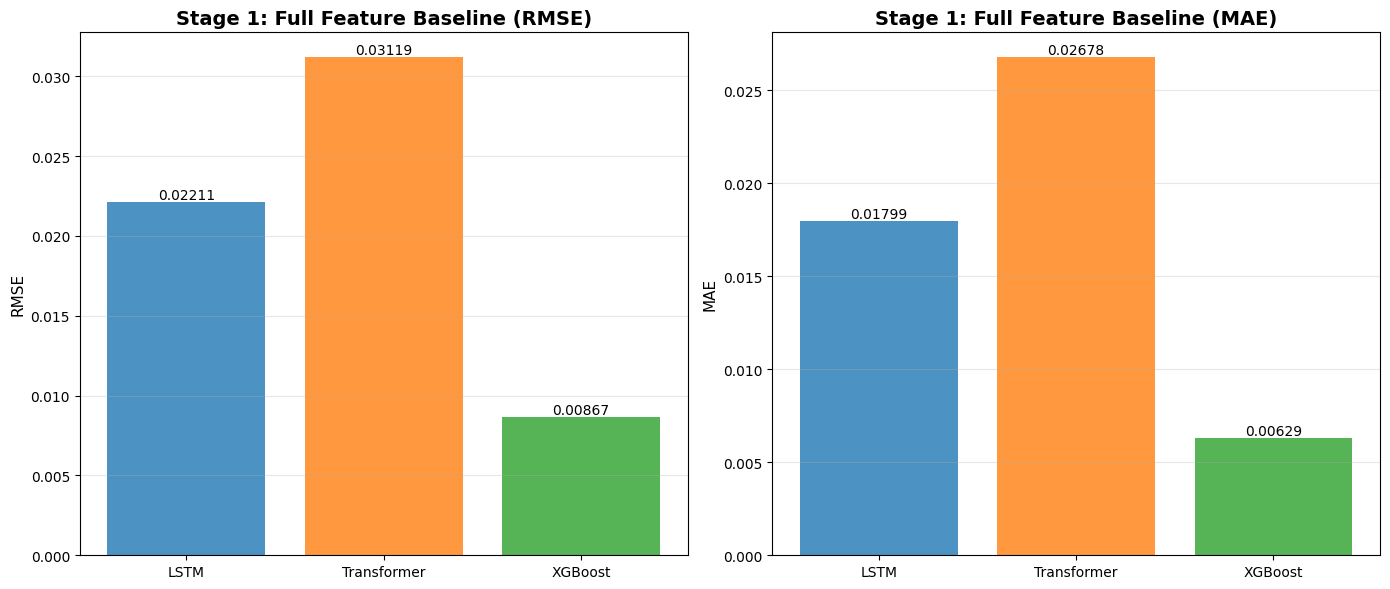

圖表 1：基準比較已儲存


In [10]:
print("\n" + "="*80)
print("[Part 8/8] 結果視覺化與分析")
print("="*80)

fig1 = plt.figure(figsize=(14, 6))

ax1 = plt.subplot(1, 2, 1)
models = list(baseline_results.keys())
rmse_values = [baseline_results[m]['RMSE'] for m in models]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
bars = ax1.bar(models, rmse_values, color=colors, alpha=0.8)
ax1.set_title('Stage 1: Full Feature Baseline (RMSE)', fontsize=14, fontweight='bold')
ax1.set_ylabel('RMSE', fontsize=11)
ax1.grid(True, alpha=0.3, axis='y')

for bar, val in zip(bars, rmse_values):
    height = bar.get_height()
    if not np.isnan(height):
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.5f}', ha='center', va='bottom', fontsize=10)

ax2 = plt.subplot(1, 2, 2)
mae_values = [baseline_results[m]['MAE'] for m in models]
bars = ax2.bar(models, mae_values, color=colors, alpha=0.8)
ax2.set_title('Stage 1: Full Feature Baseline (MAE)', fontsize=14, fontweight='bold')
ax2.set_ylabel('MAE', fontsize=11)
ax2.grid(True, alpha=0.3, axis='y')

for bar, val in zip(bars, mae_values):
    height = bar.get_height()
    if not np.isnan(height):
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.5f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, '01_baseline_comparison.png'), dpi=300, bbox_inches='tight')
plt.show()
plt.close()
print("圖表 1：基準比較已儲存")


[Part 8/8] 結果視覺化與分析


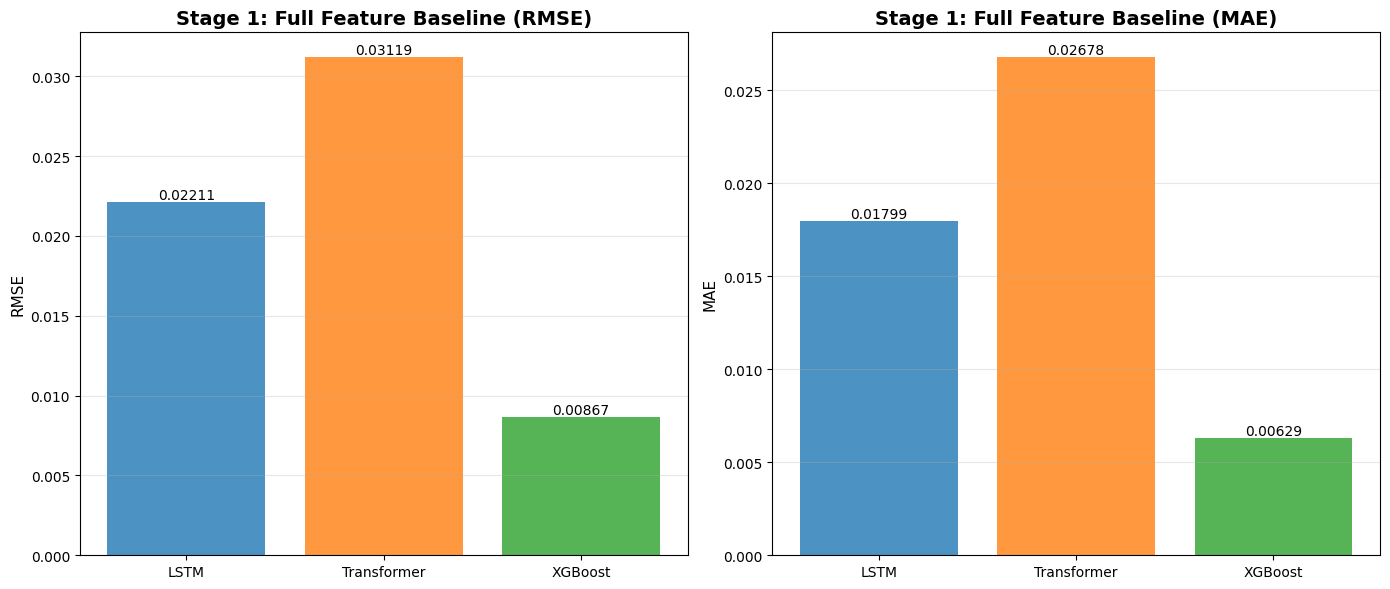

圖表 1：基準比較已儲存


In [11]:
print("\n" + "="*80)
print("[Part 8/8] 結果視覺化與分析")
print("="*80)

fig1 = plt.figure(figsize=(14, 6))


ax1 = plt.subplot(1, 2, 1)
models = list(baseline_results.keys())
rmse_values = [baseline_results[m]['RMSE'] for m in models]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
bars = ax1.bar(models, rmse_values, color=colors, alpha=0.8)
ax1.set_title('Stage 1: Full Feature Baseline (RMSE)', fontsize=14, fontweight='bold')
ax1.set_ylabel('RMSE', fontsize=11)
ax1.grid(True, alpha=0.3, axis='y')

for bar, val in zip(bars, rmse_values):
    height = bar.get_height()
    if not np.isnan(height):
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.5f}', ha='center', va='bottom', fontsize=10)

ax2 = plt.subplot(1, 2, 2)
mae_values = [baseline_results[m]['MAE'] for m in models]
bars = ax2.bar(models, mae_values, color=colors, alpha=0.8)
ax2.set_title('Stage 1: Full Feature Baseline (MAE)', fontsize=14, fontweight='bold')
ax2.set_ylabel('MAE', fontsize=11)
ax2.grid(True, alpha=0.3, axis='y')

for bar, val in zip(bars, mae_values):
    height = bar.get_height()
    if not np.isnan(height):
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.5f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, '01_baseline_comparison.png'), dpi=300, bbox_inches='tight')
plt.show()
plt.close()
print("圖表 1：基準比較已儲存")


[Part 8/8] 結果視覺化與分析


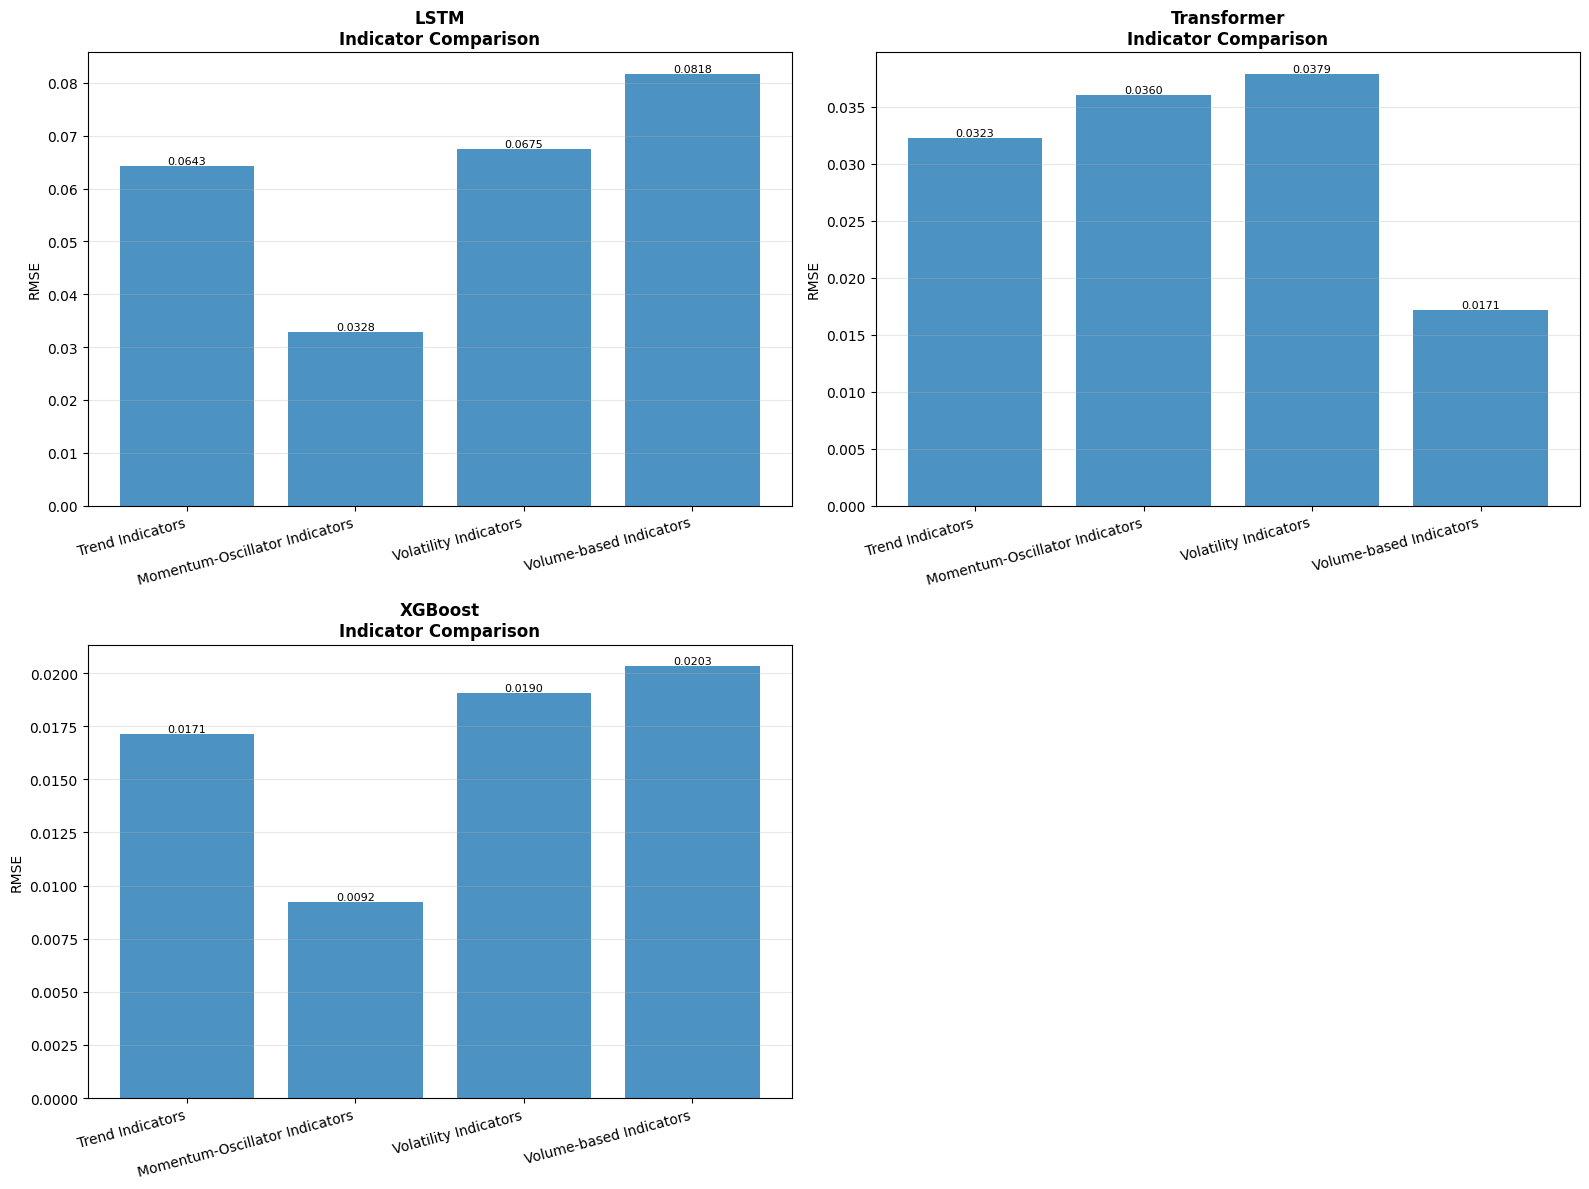

圖表 3：各模型的指標比較已儲存


In [12]:
print("\n" + "="*80)
print("[Part 8/8] 結果視覺化與分析")
print("="*80)

model_names = list(indicator_results.keys())
groups = list(indicator_results[model_names[0]].keys())


fig3 = plt.figure(figsize=(16, 12))

for idx, model_name in enumerate(model_names, 1):
    ax = plt.subplot(2, 2, idx)

    rmse_vals = []
    for group in groups:
        if group in indicator_results[model_name]:
            rmse = indicator_results[model_name][group]['RMSE']
            rmse_vals.append(rmse if not np.isnan(rmse) else 0)
        else:
            rmse_vals.append(0)

    x_pos = np.arange(len(groups))
    bars = ax.bar(x_pos, rmse_vals, alpha=0.8)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(groups, rotation=15, ha='right')
    ax.set_title(f'{model_name}\nIndicator Comparison', fontsize=12, fontweight='bold')
    ax.set_ylabel('RMSE', fontsize=10)
    ax.grid(True, alpha=0.3, axis='y')

    for bar, val in zip(bars, rmse_vals):
        if val > 0:
            ax.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                   f'{val:.4f}', ha='center', va='bottom', fontsize=8, rotation=0)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, '03_model_indicator_comparison.png'), dpi=300, bbox_inches='tight')
plt.show()
plt.close()
print("圖表 3：各模型的指標比較已儲存")

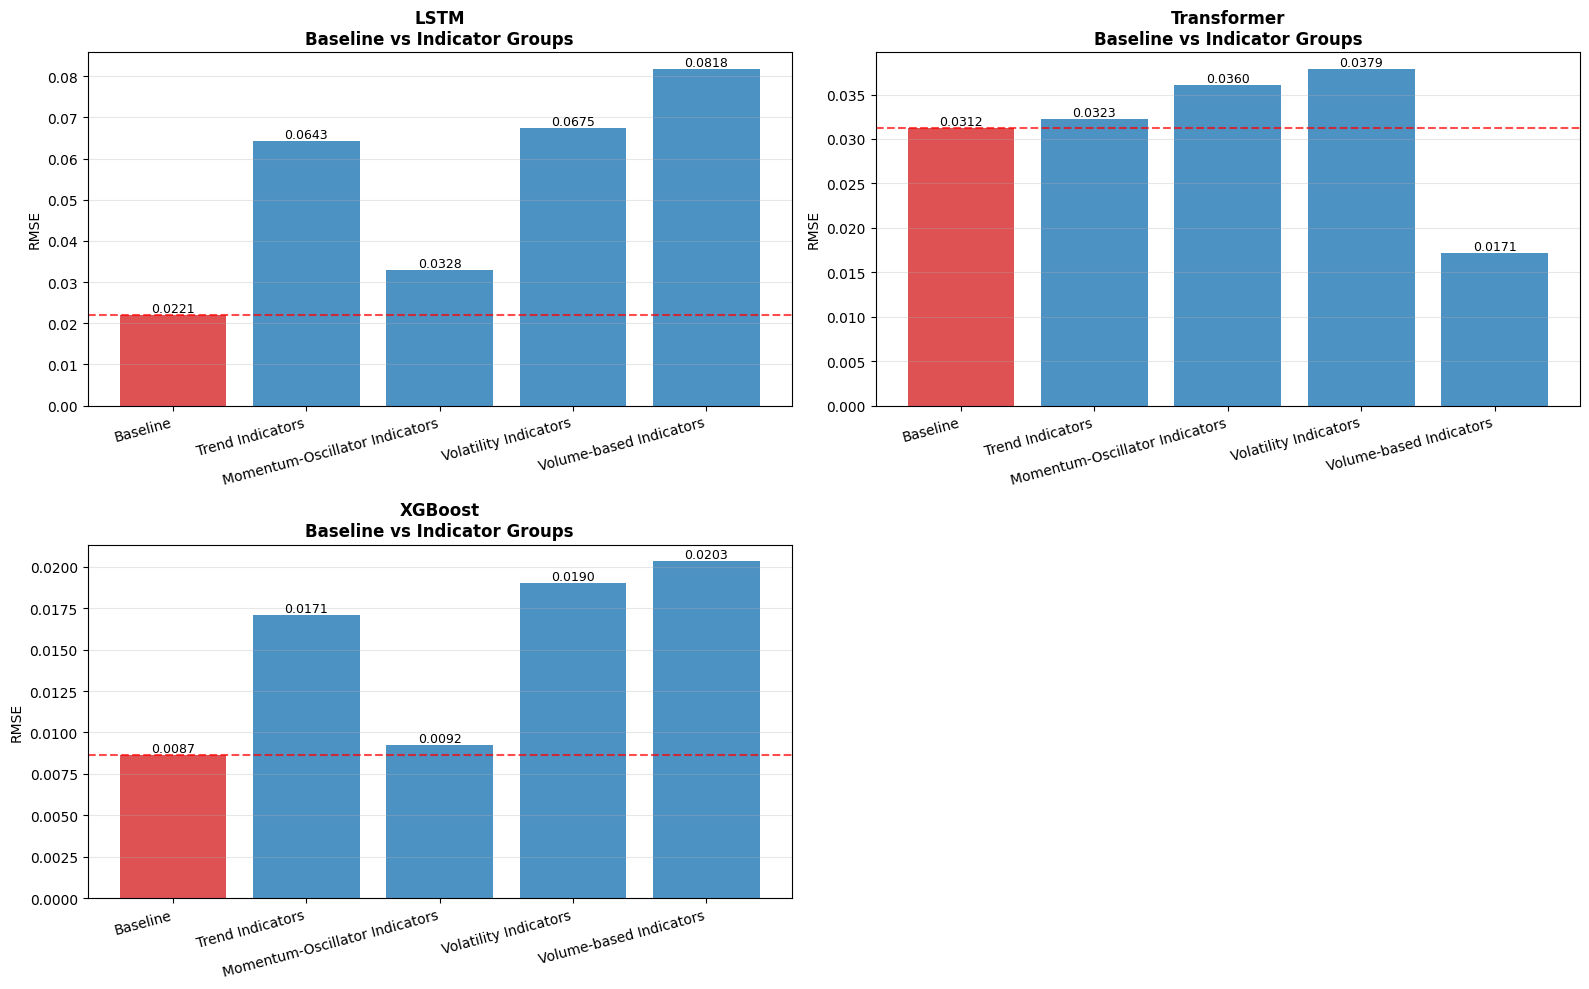

圖表 4：基準 vs 指標比較已儲存


In [13]:
fig4 = plt.figure(figsize=(16, 10))

for idx, model_name in enumerate(model_names, 1):
    ax = plt.subplot(2, 2, idx)

    baseline_rmse = baseline_results[model_name]['RMSE'] if not np.isnan(baseline_results[model_name]['RMSE']) else 0
    group_labels = ['Baseline'] + groups
    rmse_vals = [baseline_rmse]
    for group in groups:
        if group in indicator_results[model_name]:
            rmse = indicator_results[model_name][group]['RMSE']
            rmse_vals.append(rmse if not np.isnan(rmse) else 0)
        else:
            rmse_vals.append(0)

    x_pos = np.arange(len(group_labels))
    colors_chart = ['#d62728'] + ['#1f77b4'] * len(groups)
    bars = ax.bar(x_pos, rmse_vals, color=colors_chart, alpha=0.8)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(group_labels, rotation=15, ha='right')
    ax.set_title(f'{model_name}\nBaseline vs Indicator Groups', fontsize=12, fontweight='bold')
    ax.set_ylabel('RMSE', fontsize=10)
    ax.grid(True, alpha=0.3, axis='y')

    for bar, val in zip(bars, rmse_vals):
        if val > 0:
            ax.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                   f'{val:.4f}', ha='center', va='bottom', fontsize=9)

    ax.axhline(y=baseline_rmse, color='r', linestyle='--', linewidth=1.5, alpha=0.7)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, '04_baseline_vs_indicators.png'), dpi=300, bbox_inches='tight')
plt.show()
plt.close()
print("圖表 4：基準 vs 指標比較已儲存")

In [14]:
print("\n" + "="*80)
print("生成實驗報告")
print("="*80)

report = f"""
{'='*80}
股票價格時間序列預測 - 兩階段特徵工程實驗報告
{'='*80}

實驗設定：
-----------
股票代號：{ticker}
時間範圍：{start_date} 至 {end_date}
訓練/驗證/測試：{X_train.shape[0]}/{X_val.shape[0]}/{X_test.shape[0]} 個樣本
回看期間：{lookback_period} 天
總特徵數：{len(ALL_FEATURES)}

{'='*80}
階段 1：全特徵基準結果
{'='*80}

使用全部 {len(ALL_FEATURES)} 個特徵建立基準性能：

┌──────────────┬──────────────┬──────────────┬──────────────┐
│    模型      │     MSE      │     MAE      │     RMSE     │
├──────────────┼──────────────┼──────────────┼──────────────┤
"""

model_names = list(baseline_results.keys()) # Ensure model_names is defined

for model in model_names:
    mse = baseline_results[model]['MSE']
    mae = baseline_results[model]['MAE']
    rmse = baseline_results[model]['RMSE']
    # Add baseline results to the report string
    report += f"│ {model:12s} │ {mse:>12.6f} │ {mae:>12.6f} │ {rmse:>12.6f} │\n"

report += """└──────────────┴──────────────┴──────────────┴──────────────┘

"""

report += f"""
{'='*80}
階段 2：指標分類結果
{'='*80}

"""
groups = list(INDICATOR_GROUPS.keys()) # Ensure groups is defined

for group_name in groups:
    report += f"\n{group_name}:\n"
    report += f"  特徵：{INDICATOR_GROUPS[group_name]}\n"
    for model in model_names:
        if group_name in indicator_results[model]:
            rmse = indicator_results[model][group_name]['RMSE']
            mae = indicator_results[model][group_name]['MAE']
            if not np.isnan(rmse):
                # Need to get baseline RMSE for percentage difference calculation
                baseline_rmse = baseline_results[model]['RMSE'] if model in baseline_results and not np.isnan(baseline_results[model]['RMSE']) else float('inf')
                if baseline_rmse != float('inf') and baseline_rmse != 0:
                     pct_diff = ((rmse - baseline_rmse) / baseline_rmse) * 100
                     report += f"  - {model:12s}: RMSE={rmse:.6f}, MAE={mae:.6f} (相較基準：{pct_diff:+.1f}%)\n"
                else:
                     report += f"  - {model:12s}: RMSE={rmse:.6f}, MAE={mae:.6f} (相較基準：N/A)\n"
            else:
                report += f"  - {model:12s}: N/A\n"

report += "\n--- 各指標群組最佳模型 ---\n"
for group_name in groups:
    best_model = None
    best_rmse = float('inf')
    for model in model_names:
        if group_name in indicator_results[model]:
            rmse = indicator_results[model][group_name]['RMSE']
            if not np.isnan(rmse) and rmse < best_rmse:
                best_rmse = rmse
                best_model = model
    if best_model:
        report += f"   - {group_name}：最佳模型為 {best_model} (RMSE: {best_rmse:.6f})\n"


print(report)

# 儲存報告
with open(os.path.join(OUTPUT_DIR, 'Experiment_Report_2Stage.txt'), 'w', encoding='utf-8') as f:
    f.write(report)


生成實驗報告

股票價格時間序列預測 - 兩階段特徵工程實驗報告

實驗設定：
-----------
股票代號：AAPL
時間範圍：2022-01-01 至 2025-10-31
訓練/驗證/測試：738/92/93 個樣本
回看期間：30 天
總特徵數：23

階段 1：全特徵基準結果

使用全部 23 個特徵建立基準性能：

┌──────────────┬──────────────┬──────────────┬──────────────┐
│    模型      │     MSE      │     MAE      │     RMSE     │
├──────────────┼──────────────┼──────────────┼──────────────┤
│ LSTM         │     0.000489 │     0.017992 │     0.022111 │
│ Transformer  │     0.000973 │     0.026781 │     0.031194 │
│ XGBoost      │     0.000075 │     0.006289 │     0.008665 │
└──────────────┴──────────────┴──────────────┴──────────────┘


階段 2：指標分類結果


Trend Indicators:
  特徵：['SMA_5', 'SMA_10', 'SMA_20', 'EMA_12', 'EMA_26', 'MACD', 'MACD_SIGNAL', 'MACD_HIST']
  - LSTM        : RMSE=0.064329, MAE=0.050629 (相較基準：+190.9%)
  - Transformer : RMSE=0.032275, MAE=0.028719 (相較基準：+3.5%)
  - XGBoost     : RMSE=0.017113, MAE=0.013479 (相較基準：+97.5%)

Momentum-Oscillator Indicators:
  特徵：['RSI_14', 'STOCH_K', 'STOCH_D', 'CCI_20', 'ROC']
  - LST